---
title: MNIST
categories: deep-learning
date: 2020-10-26
---
[MNIST](https://eipi10.cn/others/2020/10/22/dataset)（Mixed National Institute of Standards and Technology）数据集是著名的手写数字数据集，被誉为数据科学领域的`果蝇`。本文使用Tensorflow对这个数据集进行分类，将会尝试多个模型，从简单的到复杂的，直至接近State-of-the-Art。

![img](images/8389494-c279133be28eb263.webp)

目前MNIST数据集State-of-the-Art的排名如下，详见[Image Classification on MNIST](https://paperswithcode.com/sota/image-classification-on-mnist)。

![image-20201209133852953](images/image-20201209133852953.png)

从时间轴上看，MCDNN在2013年就取得了99.77%的准确率，应该说由于MNIST数据集比较简单，各家算法取得的结果都非常接近，几乎已经接近极限了。

![image-20201209232922029](images/image-20201209232922029.png)

## 数据

MNIST数据集包含60,000张training图片和10,000张test图片，每张图片由$28\times28$ 个像素点构成，每个像素点用一个灰度值(0−2550−255)表示。首先引入所用的包。

In [1]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import tensorflow as tf
import time

from IPython.display import display, Image
from sklearn.metrics import confusion_matrix
from pprint import pprint
from tensorflow.keras import datasets, models, Model, layers, callbacks, losses, optimizers, preprocessing

然后是一些基础设置和公共函数，

In [2]:
# 设置日志
logging.basicConfig(format='%(asctime)s: %(levelname)s: %(message)s')
logging.root.setLevel(level=logging.INFO)

# 设置GPU内存使用上限
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
print(gpus)
tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)]
)

# 保存模型的loss, accuracy等指标
models = {}

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
models = {}

In [4]:
class TaskTime:
    '''用于显示执行时间'''
    
    def __init__(self, task_name, show_start=False):
        self.show_start = show_start
        self.task_name = task_name
        self.start_time = time.time()

    def elapsed_time(self):
        return time.time()-self.start_time

    def __enter__(self):
        if self.show_start:
            logging.info('start {}'.format(self.task_name))
        return self;

    def __exit__(self, exc_type, exc_value, exc_tb):
        time.sleep(0.5)
        logging.info('finish {} [elapsed time: {:.2f} seconds]'.format(self.task_name, self.elapsed_time()))
        
def get_weight_num(model):
    '''得到模型可训练参数的个数'''
    return np.sum([np.prod(p.shape) for p in model.trainable_weights])

def show_images(images, labels, x_num=6, y_num=6, figsize=(8,8), classes=None):
    '''显示图片'''
    plt.figure(figsize=figsize)
    channel_count = images.shape[-1]
    for i in range(x_num*y_num):
        plt.subplot(x_num, y_num, i+1)
        if channel_count==1:
            plt.imshow(images[i], cmap='gray')
        else:
            plt.imshow(images[i])
        label = labels[i] if classes is None else classes[labels[i]]
        plt.title("{}".format(label))
        plt.xticks([])
        plt.yticks([])    

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.3, hspace=0.3)      
    plt.show()
    
def plot_distribution(train_labels, test_labels, classes=None):
    '''打印类的分布'''
    def plot_dist(labels, title, color='blue', width = 0.7):
        bin_count = np.bincount(labels)
        bin_percentage = bin_count/len(labels)
        rects = plt.bar(np.arange(len(bin_count)), bin_count, width, color=color)
        plt.title(title)
        if classes is None:
            plt.xticks(range(len(bin_count))) 
        else:
            plt.xticks(range(len(bin_count)), labels=classes, rotation = 45) 
        plt.ylim(0, max(bin_count)*1.1) 
        
        for i, r in enumerate(rects):
            plt.annotate('{:0.1f}%'.format(int(bin_percentage[i]*100)),
                        xy=(r.get_x() + r.get_width() / 2, r.get_height()),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')        
            
    plt.figure(figsize=(16, 4))
    plt.subplot(121)
    plot_dist(train_labels, 'Train', color='teal')
    plt.subplot(122)
    plot_dist(test_labels, 'Test', color='coral')

    plt.show()    
    
def train(model, epochs, verbose=True):    
    '''要求模型设置name属性，用于保存模型。''' 
    checkpoint_best_only = callbacks.ModelCheckpoint(filepath=model.checkpoint_path,
                                                     monitor='val_accuracy',
                                                     save_weights_only=True, 
                                                     save_best_only=True,
                                                     verbose=False)
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, min_lr=0.0001, patience=int(epochs*0.2), verbose=verbose) 
    early_stopping = callbacks.EarlyStopping(monitor='val_accuracy', patience=int(epochs*0.3))  
    
    with TaskTime('training', True) as t: 
        history = model.fit(train_dataset, validation_data=val_dataset,
                            epochs=epochs, verbose=verbose, 
                            callbacks=[checkpoint_best_only, reduce_lr, early_stopping])
        history.train_time = t.elapsed_time()
    return history  

def plot_history(history):
    '''显示训练的loss和accuracy的走势图'''
    plt.figure(figsize=(16, 5))
    epochs = range(1, len(history.history['accuracy'])+1)
    plt.subplot(121)
    plt.plot(epochs, history.history['accuracy'])
    plt.plot(epochs, history.history['val_accuracy'])
    plt.title('Accuracy vs. epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.xticks(epochs)
    plt.legend(['Training', 'Validation'], loc='lower right')

    plt.subplot(122)
    plt.plot(epochs, history.history['loss'])
    plt.plot(epochs, history.history['val_loss'])
    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.xticks(epochs)
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.show()    
    
def show_models(models):     
    '''按照test_accuracy倒序显示所有模型的信息'''
    models_remove1 = {key:{key1:value1 for key1, value1 in value.items() if key1 != 'model'}  for key, value in models.items()}
    df_models = pd.DataFrame.from_dict(models_remove1, orient='index')
    df_models = df_models.sort_values('test_accuracy', ascending=False) 
    display(df_models)
       
def evaluate_show(model, train_time, 
                  train_dataset, 
                  val_dataset, 
                  test_dataset, 
                  models):
    '''评估当前模型，并且显示所有模型的信息'''
    train_loss, train_accuracy = model.evaluate(train_dataset, verbose=False)
    val_loss, val_accuracy = model.evaluate(val_dataset, verbose=False)
    test_loss, test_accuracy = model.evaluate(test_dataset, verbose=False)
    if  model.name not in models or models[model.name]['test_accuracy']<test_accuracy:
        models[model.name] = {'train_loss':round(train_loss, 6), 
                              'train_accuracy':round(train_accuracy, 4), 
                              'val_loss':round(val_loss, 6), 
                              'val_accuracy':round(val_accuracy, 4),    
                              'test_loss':round(test_loss, 6), 
                              'test_accuracy':round(test_accuracy, 4),                               
                              'weight_number':get_weight_num(model), 
                              'model':model,
                              'train_time':round(train_time,0)
                             }    
    show_models(models)    
    
def plot_confusion_matrix(model1, images, labels, model2=None, classes=None):
    '''打印混淆矩阵'''
    def plot_cm(model):
        predictions = model.predict(images).argmax(axis=-1)               
        cm = confusion_matrix(labels, predictions)
        bin_count = np.bincount(labels)
        if classes is None: 
            index = range(len(bin_count))      
            columns = range(len(bin_count))  
        else:
            index = classes     
            columns = classes           
        df_cm = pd.DataFrame(cm, index=index, columns=columns)
        
        plt.title("{} - Confusion matrix".format(model.name))
        sns.heatmap(df_cm, annot=True, fmt='g',cmap='coolwarm')
        if classes is not None: plt.xticks(rotation = 45)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")

    
    if model2 is not None:
        plt.figure(figsize=(16, 6))
        plt.subplot(1, 2, 1)
        plot_cm(model1)
        plt.subplot(1, 2, 2)
        plot_cm(model2)         
    else:  
        plt.figure(figsize=(8, 6))
        plot_cm(model1)
    
    plt.show()    
    
def plot_predicted_sample(models, images, labels, sample_count=5, show_error=True, classes=None):    
    '''查看一些样本的分类情况'''
    def get_class(label):
        if classes is None:
            return label
        else:
            return classes[label]

    def plot_var(model, image, label):
        predict = np.squeeze(tf.nn.softmax(model.predict(image)).numpy())
        max_like = np.argmax(predict)
        max_like_value = predict[max_like]

        if classes is None:
            _classes = range(label_count)
            plt.text(max_like-0.5, max_like_value+0.02, 
                     '{:0.1f}%'.format(max_like_value*100), fontsize=8)            
            plt.bar(_classes, predict, width=0.9, color='steelblue', alpha=0.8) 
            plt.ylim(0, 1.2)
            plt.xticks(range(label_count), _classes, fontsize=8)          
        else:
            _classes = classes
            plt.text(max_like_value+0.02, max_like, 
                     '{:0.1f}%'.format(max_like_value*100), fontsize=8)             
            plt.barh(_classes, predict, height=0.9, color='steelblue', alpha=0.8) 
            plt.xlim(0, 1.2)
            plt.yticks(range(label_count), _classes, fontsize=8)
        plt.title('{}: {}'.format(model.name, get_class(max_like)), fontsize=10)
                  
    if show_error:
        base_predictions = models[0].predict(images).argmax(axis=-1)  
        error_indexes = base_predictions != labels
        error_images = images[error_indexes]
        error_labels = labels[error_indexes]
        sample_indexes = np.random.randint(len(error_images), size=sample_count)  
        sample_images = error_images[sample_indexes]
        sample_labels = error_labels[sample_indexes]
    else:
        sample_indexes = np.random.randint(len(labels), size=sample_count)  
        sample_images = images[sample_indexes]
        sample_labels = labels[sample_indexes]
    
    bin_count = np.bincount(labels)
    label_count = len(bin_count)
    column_count = len(models)+1 
    if classes is None:
        plt.figure(figsize=(2.2*column_count, sample_count*2.2))
    else:
        plt.figure(figsize=(2.8*column_count, sample_count*2.8))
    for i in range(sample_count):
        plt.subplot(sample_count, column_count, column_count*i+1)
        plt.imshow(np.squeeze(sample_images[i]), cmap='gray', interpolation='none')
        plt.title('actual: {}'.format(get_class(sample_labels[i])), fontsize=10)
        plt.xticks([])
        plt.yticks([])

        for j, model in enumerate(models):
            plt.subplot(sample_count, column_count, column_count*i+j+2)
            plot_var(model, sample_images[i:i+1], sample_labels[i])

    plt.subplots_adjust(wspace=0.5, hspace=0.5)         
    plt.show()    
    
def plot_model_structure(model):    
    '''打印模型的结构'''
    img = tf.keras.utils.plot_model(model, '{}.png'.format(model.name), show_shapes=True) 
    display(img)
    
def load_best_checkpoint(model):
    '''加载最佳的checkpoint'''
    model.load_weights(model.checkpoint_path)
    return model    


下面开始加载数据。

In [5]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

train_images = np.expand_dims(train_images, axis=-1) 
test_images = np.expand_dims(test_images, axis=-1)
train_images = train_images/255.0
test_images = test_images/255.0

print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

(60000, 28, 28, 1) (60000,)
(10000, 28, 28, 1) (10000,)


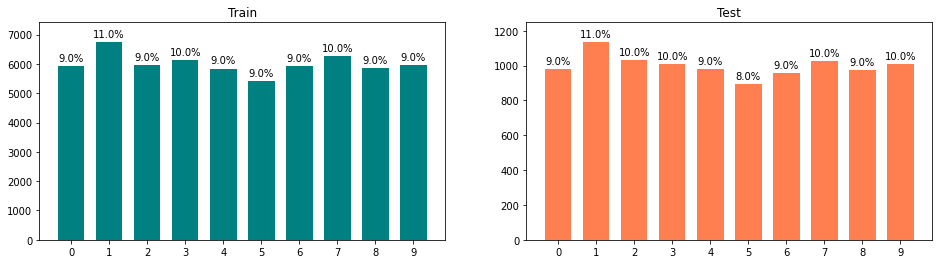

In [6]:
plot_distribution(train_labels, test_labels)

![image-20201210224132607](images/image-20201210224132607.png)

然后创建train，validatiaon和test数据集。

In [7]:
batch_size = 32

train_val_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)) 
train_val_size = train_images.shape[0]
# reshuffle_each_iteration必须设置成False，否则train_dataset和val_dataset会有重复
train_val_dataset = train_val_dataset.shuffle(train_val_size, reshuffle_each_iteration = False)  

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.batch(batch_size)

train_size = int(0.9*train_val_size)
train_dataset = train_val_dataset.take(train_size)
train_dataset = train_dataset.shuffle(train_size, reshuffle_each_iteration = True) 
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

val_dataset = train_val_dataset.skip(train_size)
val_dataset = val_dataset.shuffle(train_val_size-train_size, reshuffle_each_iteration = True)
val_dataset = val_dataset.batch(batch_size)

input_shape = train_dataset.element_spec[0].shape[1:]

示例图片如下：

![image-20201209150908574](images/image-20201209150908574.png)

## MLP

首先，尝试用经典的多层感知器（Muti-Layer Perception）来进行分类。下面模型是典型的三层结构，有101,770个参数。

In [8]:
def get_mlp(input_shape, learning_rate=0.001):
    input = layers.Input(shape=input_shape)
    x = layers.Flatten()(input)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(10)(x)  
    
    model = Model(inputs=input, outputs=x, name='mlp') 
    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate),
                  loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])  

    model.checkpoint_path = './checkpoints/{}/checkpoint'.format(model.name)
    return model

mlp_model = get_mlp(input_shape)
mlp_model.summary()

Model: "mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


![image-20201210224246538](images/image-20201210224246538.png)

下面是模型训练的代码。

2020-12-22 01:29:28,998: INFO: start training


Epoch 1/20
1687/1687 [==============================] - 5s 3ms/step - loss: 0.3299 - accuracy: 0.9038 - val_loss: 0.1617 - val_accuracy: 0.9517
Epoch 2/20
1687/1687 [==============================] - 5s 3ms/step - loss: 0.1664 - accuracy: 0.9500 - val_loss: 0.1177 - val_accuracy: 0.9652
Epoch 3/20
1687/1687 [==============================] - 5s 3ms/step - loss: 0.1308 - accuracy: 0.9604 - val_loss: 0.1028 - val_accuracy: 0.9680
Epoch 4/20
1687/1687 [==============================] - 5s 3ms/step - loss: 0.1081 - accuracy: 0.9666 - val_loss: 0.0945 - val_accuracy: 0.9707
Epoch 5/20
1687/1687 [==============================] - 5s 3ms/step - loss: 0.0942 - accuracy: 0.9702 - val_loss: 0.0874 - val_accuracy: 0.9728
Epoch 6/20
1687/1687 [==============================] - 5s 3ms/step - loss: 0.0848 - accuracy: 0.9733 - val_loss: 0.0853 - val_accuracy: 0.9742
Epoch 7/20
1687/1687 [==============================] - 5s 3ms/step - loss: 0.0742 - accuracy: 0.9767 - val_loss: 0.0892 - val_accuracy:

2020-12-22 01:31:13,058: INFO: finish training [elapsed time: 104.06 seconds]


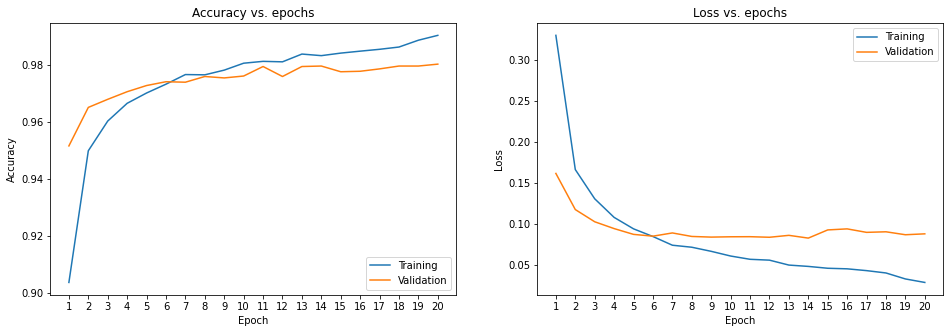

In [9]:
history = train(mlp_model, epochs=20)
plot_history(history)

![image-20201211093824914](images/image-20201211093824914.png)

可以看到对于训练数据的准确率基本趋近于100%了。下面看看Loss和Accuracy的走势。

![image-20201211093903782](images/image-20201211093903782.png)

下面评估一下模型。可以看到测试数据的准确率是98%左右，其实已经不错了。由于训练数据的准确率已经高达99.9%，这意味着模型几乎已经获得（它所能学到的）所有的模式了，再增加训练时间，也没有用了。

In [10]:
mlp_model.predict(test_images[0:1])

array([[-15.487799 , -21.569132 ,  -5.819387 ,   0.488236 , -35.01544  ,
         -8.452358 , -35.627277 ,  14.5443   ,  -7.8102016,  -4.1832533]],
      dtype=float32)

,train_loss,train_accuracy,val_loss,val_accuracy,test_loss,test_accuracy,weight_number,train_time
mlp,0.00605,0.9987,0.088101,0.9803,0.072507,0.9813,101770,104.0


------------------------------------------------------------------------------------------------------------------------


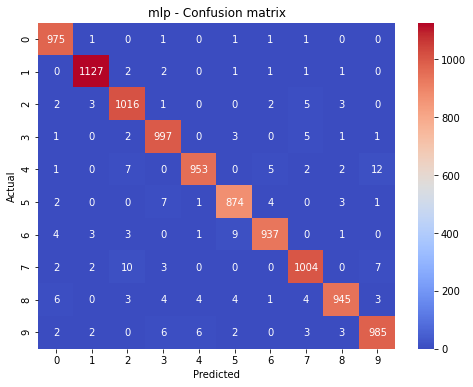

------------------------------------------------------------------------------------------------------------------------


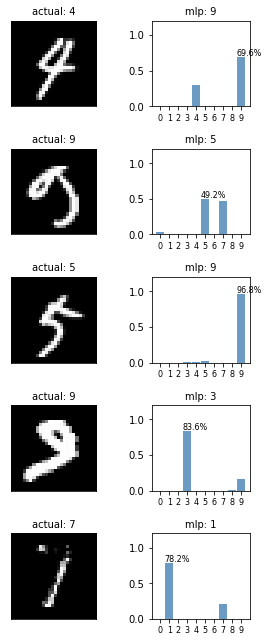

In [11]:
# 评估
mlp_model = load_best_checkpoint(get_mlp(input_shape))
evaluate_show(mlp_model, 
              train_time=history.train_time,
              train_dataset=train_dataset, 
              val_dataset=val_dataset, 
              test_dataset=test_dataset, 
              models=models
             )

# 混淆矩阵
print('-'*120)
plot_confusion_matrix(mlp_model, 
                      images=test_images, 
                      labels=test_labels)   

# 模型对比
print('-'*120)
plot_predicted_sample([mlp_model], 
                      images=test_images, 
                      labels=test_labels,
                      sample_count=5)   

## Lenet

In [12]:
def get_lenet(input_shape, learning_rate=0.001):
    input = layers.Input(shape=input_shape)
    x = layers.Conv2D(6, (5, 5), activation='relu', padding='same')(input)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv2D(16, (5, 5), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)   
    x = layers.Dropout(0.3)(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(120, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(84, activation='relu')(x)   
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(10)(x)  
    
    model = Model(inputs=input, outputs=x, name='lenet') 
    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate),
                  loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])  

    model.checkpoint_path = './checkpoints/{}/checkpoint'.format(model.name)
    return model    

# 创建模型b
lenet_model = get_lenet(input_shape)
lenet_model.summary()

Model: "lenet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 6)         24        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 6)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 10, 16)        64    

2020-12-22 01:31:21,854: INFO: start training


Epoch 1/20
1687/1687 [==============================] - 8s 5ms/step - loss: 0.4358 - accuracy: 0.8623 - val_loss: 0.0874 - val_accuracy: 0.9743
Epoch 2/20
1687/1687 [==============================] - 7s 4ms/step - loss: 0.1607 - accuracy: 0.9529 - val_loss: 0.0597 - val_accuracy: 0.9813
Epoch 3/20
1687/1687 [==============================] - 7s 4ms/step - loss: 0.1310 - accuracy: 0.9624 - val_loss: 0.0536 - val_accuracy: 0.9845
Epoch 4/20
1687/1687 [==============================] - 7s 4ms/step - loss: 0.1092 - accuracy: 0.9676 - val_loss: 0.0497 - val_accuracy: 0.9843
Epoch 5/20
1687/1687 [==============================] - 7s 4ms/step - loss: 0.1013 - accuracy: 0.9705 - val_loss: 0.0454 - val_accuracy: 0.9858
Epoch 6/20
1687/1687 [==============================] - 7s 4ms/step - loss: 0.0915 - accuracy: 0.9732 - val_loss: 0.0443 - val_accuracy: 0.9868
Epoch 7/20
1687/1687 [==============================] - 7s 4ms/step - loss: 0.0871 - accuracy: 0.9743 - val_loss: 0.0418 - val_accuracy:

2020-12-22 01:33:59,713: INFO: finish training [elapsed time: 157.86 seconds]


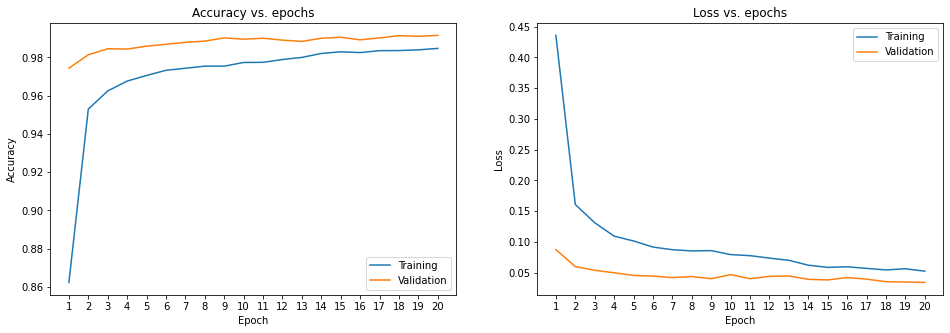

In [13]:
# 训练
history = train(lenet_model, epochs=20)
plot_history(history)

![image-20201209232416730](images/image-20201209232416730.png)

![image-20201211094805652](images/image-20201211094805652.png)

![image-20201211094821231](images/image-20201211094821231.png)

下面来评估模型，生成混淆矩阵，错误分析，以及模型对比。

,train_loss,train_accuracy,val_loss,val_accuracy,test_loss,test_accuracy,weight_number,train_time
lenet,0.016427,0.9948,0.033910,0.9915,0.028727,0.9902,61750,157.0
mlp,0.006050,0.9987,0.088101,0.9803,0.072507,0.9813,101770,104.0


------------------------------------------------------------------------------------------------------------------------


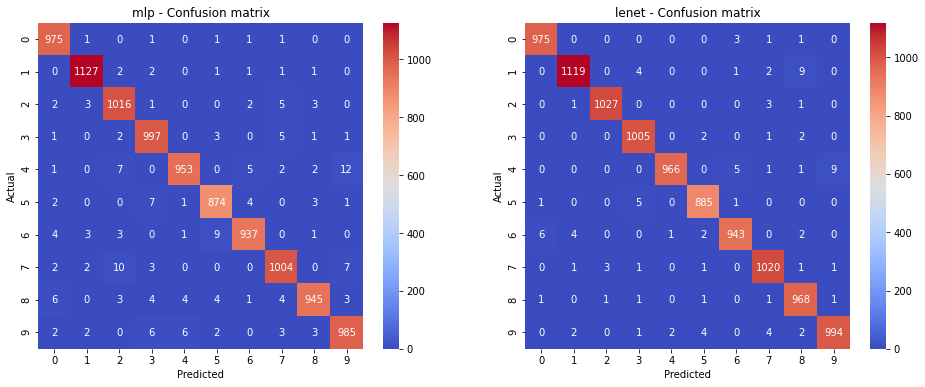

------------------------------------------------------------------------------------------------------------------------


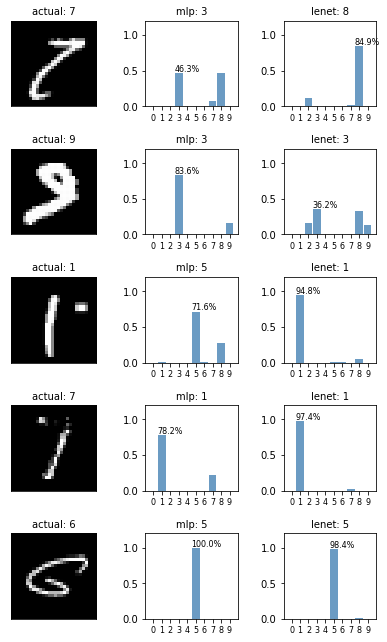

In [14]:
# 评估
lenet_model = load_best_checkpoint(get_lenet(input_shape))
evaluate_show(lenet_model, 
              train_time=history.train_time,
              train_dataset=train_dataset, 
              val_dataset=val_dataset, 
              test_dataset=test_dataset, 
              models=models
             )

# 混淆矩阵
print('-'*120)
plot_confusion_matrix(mlp_model, 
                      model2=lenet_model,
                      images=test_images, 
                      labels=test_labels)  

# 模型对比
print('-'*120)
plot_predicted_sample([mlp_model, lenet_model], 
                      images=test_images, 
                      labels=test_labels,
                      sample_count=5)   

![image-20201211095111794](images/image-20201211095111794.png)

![image-20201211095140282](images/image-20201211095140282.png)

从上面的图中，可以看到，Lenet的参数只有mlp的60%，但其的准确率比mlp提升了差不多1%。上面最后一张图中，有三列，第一列是数字图片，它们是mlp中分错的数字，第二列是mlp中的分类，第三列是lenet中的分类，可以看到lenet的确学到了一些mlp中没有的模式。下面再来看看哪些数字在lenet也分错了。

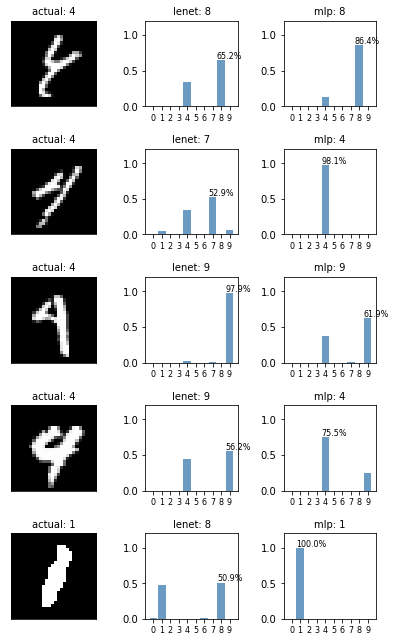

In [15]:
# 错误分析
plot_predicted_sample([lenet_model, mlp_model], 
                      images=test_images, 
                      labels=test_labels,
                      sample_count=5)   

![image-20201211095608593](images/image-20201211095608593.png)

上图中，可以看到对于部分数字的识别，mlp甚至要更好一点啊，还有一些数字，则是一起都错了。

## Custom 1

下面自己定义一个模型，看看效果如何。


In [16]:
def get_custom1(input_shape, learning_rate=0.001):
    input = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x) 
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)  
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(10)(x)  
    
    model = Model(inputs=input, outputs=x, name='custom1') 
    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate),
                  loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])  
    model.checkpoint_path = './checkpoints/{}/checkpoint'.format(model.name)
    return model   

# 创建模型
custom1_model = get_custom1(input_shape)
custom1_model.summary()

Model: "custom1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_4 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
batch_normalization_5 (Batch (None, 12, 12, 64)        256 

2020-12-22 01:34:15,162: INFO: start training


Epoch 1/20
1687/1687 [==============================] - 10s 6ms/step - loss: 0.3622 - accuracy: 0.8857 - val_loss: 0.0694 - val_accuracy: 0.9790
Epoch 2/20
1687/1687 [==============================] - 9s 6ms/step - loss: 0.1124 - accuracy: 0.9662 - val_loss: 0.0520 - val_accuracy: 0.9832
Epoch 3/20
1687/1687 [==============================] - 10s 6ms/step - loss: 0.0906 - accuracy: 0.9731 - val_loss: 0.0462 - val_accuracy: 0.9873
Epoch 4/20
1687/1687 [==============================] - 9s 6ms/step - loss: 0.0740 - accuracy: 0.9778 - val_loss: 0.0399 - val_accuracy: 0.9890
Epoch 5/20
1687/1687 [==============================] - 9s 6ms/step - loss: 0.0670 - accuracy: 0.9804 - val_loss: 0.0403 - val_accuracy: 0.9888
Epoch 6/20
1687/1687 [==============================] - 10s 6ms/step - loss: 0.0624 - accuracy: 0.9817 - val_loss: 0.0391 - val_accuracy: 0.9897
Epoch 7/20
1687/1687 [==============================] - 10s 6ms/step - loss: 0.0597 - accuracy: 0.9826 - val_loss: 0.0287 - val_accur

2020-12-22 01:37:21,562: INFO: finish training [elapsed time: 186.40 seconds]


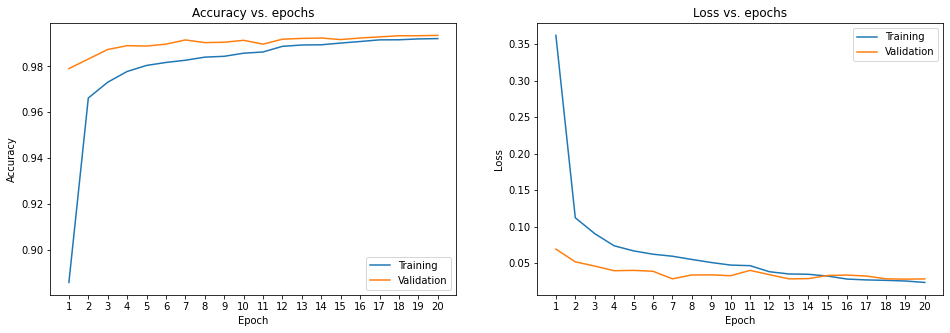

In [17]:
# 训练
history = train(custom1_model, epochs=20)
plot_history(history)

,train_loss,train_accuracy,val_loss,val_accuracy,test_loss,test_accuracy,weight_number,train_time
custom1,0.004581,0.9984,0.028601,0.9935,0.020143,0.9947,73162,186.0
lenet,0.016427,0.9948,0.033910,0.9915,0.028727,0.9902,61750,157.0
mlp,0.006050,0.9987,0.088101,0.9803,0.072507,0.9813,101770,104.0


------------------------------------------------------------------------------------------------------------------------


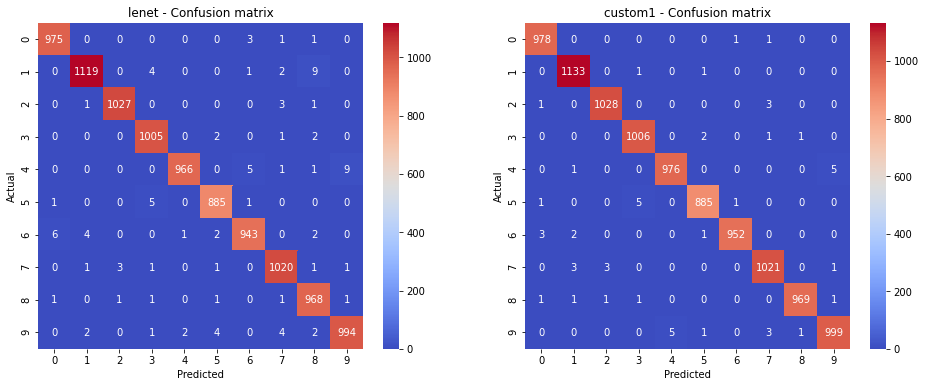

------------------------------------------------------------------------------------------------------------------------


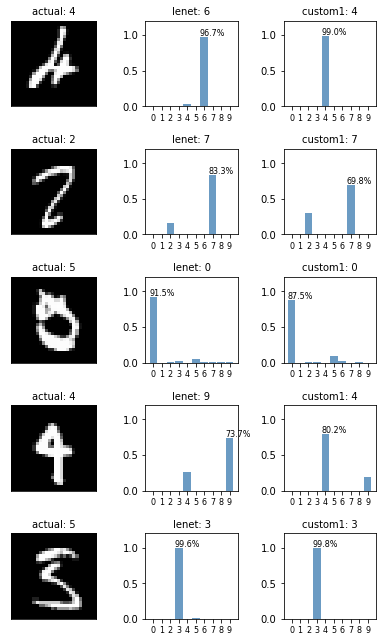

In [18]:
# 评估
custom1_model = load_best_checkpoint(get_custom1(input_shape))
evaluate_show(custom1_model, 
              train_time=history.train_time,
              train_dataset=train_dataset, 
              val_dataset=val_dataset, 
              test_dataset=test_dataset, 
              models=models
             )

# 混淆矩阵
print('-'*120)
plot_confusion_matrix(lenet_model, 
                      model2=custom1_model, 
                      images=test_images, 
                      labels=test_labels)      

# 模型对比
print('-'*120)
plot_predicted_sample([lenet_model, custom1_model], 
                      images=test_images, 
                      labels=test_labels,
                      sample_count=5)   

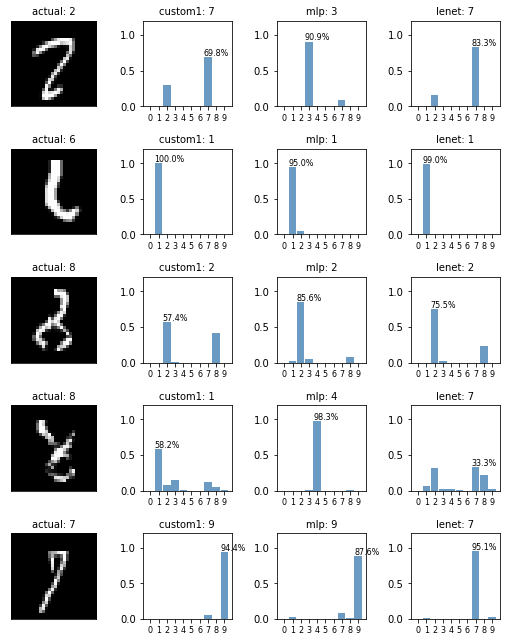

In [19]:
# 错误分析
plot_predicted_sample([custom1_model, mlp_model, lenet_model], 
                      images=test_images, 
                      labels=test_labels,
                      sample_count=5)     

## Custom 2

In [20]:
def get_custom2(input_shape, learning_rate=0.001):   
    input = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(input)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
        
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)    
    x = layers.Dense(10)(x)
    
    model = Model(inputs=input, outputs=x, name='custom2') 
    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate),
                  loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])      
    model.checkpoint_path = './checkpoints/{}/checkpoint'.format(model.name)
    return model   

# 创建模型
custom2_model = get_custom2(input_shape)
custom2_model.summary()

Model: "custom2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_10 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 14, 14, 64)        1849

2020-12-22 01:37:38,074: INFO: start training


Epoch 1/20
1687/1687 [==============================] - 11s 6ms/step - loss: 0.3485 - accuracy: 0.8898 - val_loss: 0.0961 - val_accuracy: 0.9752
Epoch 2/20
1687/1687 [==============================] - 10s 6ms/step - loss: 0.1043 - accuracy: 0.9703 - val_loss: 0.0695 - val_accuracy: 0.9815
Epoch 3/20
1687/1687 [==============================] - 10s 6ms/step - loss: 0.0803 - accuracy: 0.9786 - val_loss: 0.0507 - val_accuracy: 0.9877
Epoch 4/20
1687/1687 [==============================] - 10s 6ms/step - loss: 0.0683 - accuracy: 0.9813 - val_loss: 0.0465 - val_accuracy: 0.9878
Epoch 5/20
1687/1687 [==============================] - 10s 6ms/step - loss: 0.0587 - accuracy: 0.9841 - val_loss: 0.0519 - val_accuracy: 0.9895
Epoch 6/20
1687/1687 [==============================] - 10s 6ms/step - loss: 0.0542 - accuracy: 0.9855 - val_loss: 0.0474 - val_accuracy: 0.9888
Epoch 7/20
1687/1687 [==============================] - 10s 6ms/step - loss: 0.0505 - accuracy: 0.9868 - val_loss: 0.0424 - val_ac

2020-12-22 01:41:14,234: INFO: finish training [elapsed time: 216.16 seconds]


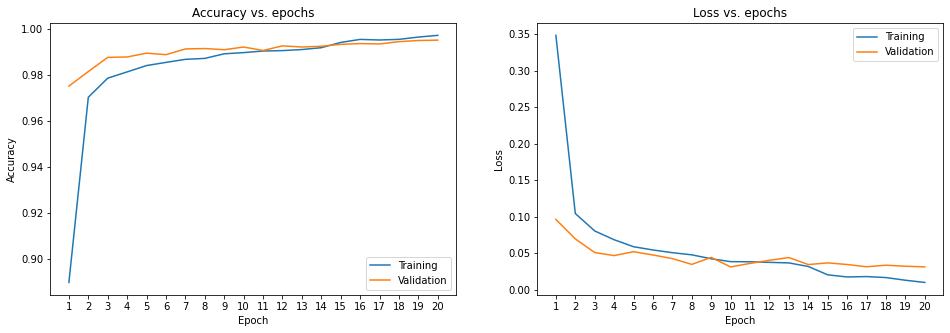

In [21]:
# 训练
history = train(custom2_model, epochs=20)
plot_history(history)

,train_loss,train_accuracy,val_loss,val_accuracy,test_loss,test_accuracy,weight_number,train_time
custom2,0.001604,0.9995,0.031055,0.9952,0.016578,0.9958,435754,216.0
custom1,0.004581,0.9984,0.028601,0.9935,0.020143,0.9947,73162,186.0
lenet,0.016427,0.9948,0.033910,0.9915,0.028727,0.9902,61750,157.0
mlp,0.006050,0.9987,0.088101,0.9803,0.072507,0.9813,101770,104.0


------------------------------------------------------------------------------------------------------------------------


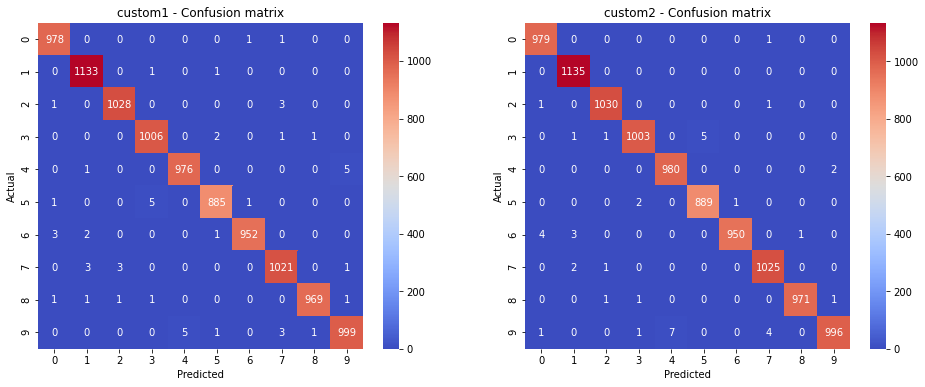

------------------------------------------------------------------------------------------------------------------------


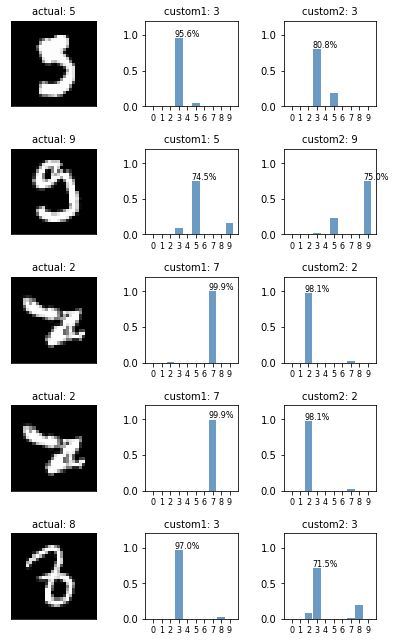

In [22]:
# 评估
custom2_model = load_best_checkpoint(get_custom2(input_shape))
evaluate_show(custom2_model, 
              train_time=history.train_time,
              train_dataset=train_dataset, 
              val_dataset=val_dataset, 
              test_dataset=test_dataset, 
              models=models
             )

# 混淆矩阵
print('-'*120)
plot_confusion_matrix(custom1_model, 
                      model2=custom2_model, 
                      images=test_images, 
                      labels=test_labels)   

# 模型对比
print('-'*120)
plot_predicted_sample([custom1_model, custom2_model], 
                      images=test_images, 
                      labels=test_labels,
                      sample_count=5)   

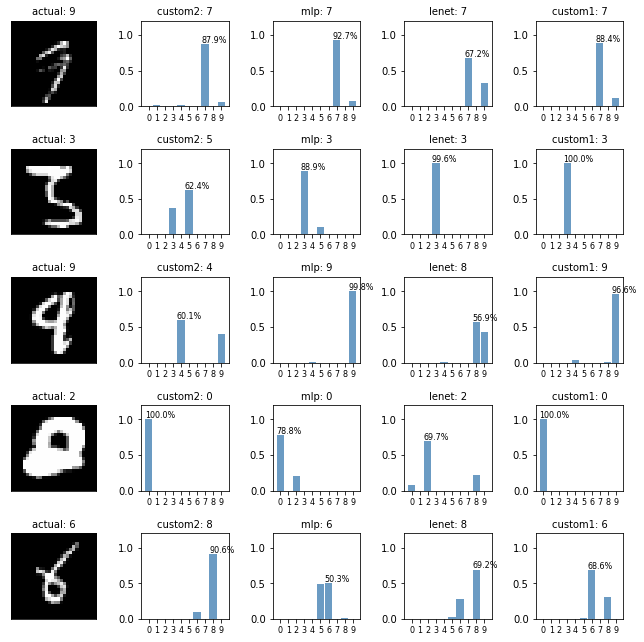

In [23]:
# 错误分析
plot_predicted_sample([custom2_model, mlp_model, lenet_model, custom1_model], 
                      images=test_images, 
                      labels=test_labels,
                      sample_count=5)     

In [24]:
# from tensorflow.keras.applications import ResNet50

In [25]:
# model.add(tf.keras.applications.resnet50.ResNet50(input_shape = (75, 75, 3), 
#                                 include_top = False, 
#                                 weights = 'imagenet'))

# model.add(L.Flatten())
# model.add(L.Dense(128, activation='relu'))
# model.add(L.Dense(10, activation='softmax'))

In [26]:
# def get_vgg16(input_shape, learning_rate=0.001):
#     input = layers.Input(shape=input_shape)
#     concat = layers.Concatenate(axis=-1)([input, input, input])
#     print(concat.shape)
#     resnet = ResNet50(input_shape=input_shape[0:-1]+[3], include_top = False, weights = 'imagenet')(concat)
#     x = layers.Flatten()(resnet)
#     x = layers.Dense(128, activation='relu')(x)                        
#     x = layers.Dense(10, activation='softmax')(x)  
    
#     model = Model(inputs=input, outputs=x, name='vgg16') 
#     model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate),
#                   loss=losses.SparseCategoricalCrossentropy(),
#                   metrics=['accuracy'])  
#     model.checkpoint_path = './checkpoints/{}/checkpoint'.format(model.name)
#     return model   

# resnet50_model = get_vgg16([32,32,1])
# resnet50_model.summary()






## 总结

归纳上面的模型训练结果，可以得出以下几个结论。

- LeNet比经典的神经网络参数要少，模型收敛更快，准确率明显提升。
- MNIST数据集过于简单了，很简单的算法也能轻易取得99%的准确率。建议采用Fashion MNIST作为替代。
- 增加卷积的深度，对于准确率的提升是有明显作用的。
- 本文中，对于Fashion MNIST最好只能取得91%的准确率，还需要采用新的模型结构才能继续提升。

## 参考

- [TensorFlow 2 quickstart for beginners](https://www.tensorflow.org/tutorials/quickstart/beginner)
- [image-classification-on-mnist](https://paperswithcode.com/sota/image-classification-on-mnist)

## 历史

- 2020-10-26：初始版本
- 2020-10-28：采用相同算法，对Fashion Mnist数据集进行分类
- 2020-11-01：pytorch训练时，增加了validation accuaracy。
- 2020-12-08：移除了pytorch的内容，集中tensorflow本身。

In [27]:
input_shape[0:-1]+[3]

TensorShape([28, 28, 3])

In [28]:
def get_block(x, filters, conv_count, kernel_size=(3, 3), padding='same', use_bn=True, 
              use_dropout=True, drop_out_rate=0.3):
    for i in range(conv_count):
        x = layers.Conv2D(filters, kernel_size, padding=padding, activation='relu')(x)
    if use_bn: x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    if use_dropout: x = layers.Dropout(drop_out_rate)(x)
    return x
    

def get_vgg9(input_shape, learning_rate=0.001, use_bn=True, use_dropout=True, drop_out_rate=0.3):   
    input = layers.Input(shape=input_shape)
    
    x = get_block(input, 64, conv_count=2, use_bn=use_bn, use_dropout=use_dropout, drop_out_rate=drop_out_rate)
    x = get_block(x, 128, conv_count=2, use_bn=use_bn, use_dropout=use_dropout, drop_out_rate=drop_out_rate)
    x = get_block(x, 256, conv_count=2, use_bn=use_bn, use_dropout=use_dropout, drop_out_rate=drop_out_rate)
#     x = get_block(x, 512, conv_count=2, use_bn=use_bn, use_dropout=use_dropout, drop_out_rate=drop_out_rate)
#     x = get_block(x, 512, conv_count=2, use_bn=use_bn, use_dropout=use_dropout, drop_out_rate=drop_out_rate)
        
    x = layers.Flatten()(x)
#     x = layers.Dense(128, activation='relu')(x)
#     if use_dropout: x = layers.Dropout(drop_out_rate)(x)  
    x = layers.Dense(128, activation='relu')(x)
    if use_dropout: x = layers.Dropout(drop_out_rate)(x)    
    x = layers.Dense(10)(x)
    
    model = Model(inputs=input, outputs=x, name='vgg9') 
    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate),
                  loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])      
    model.checkpoint_path = './checkpoints/{}/checkpoint'.format(model.name)
    return model   

# 创建模型
use_bn = True
use_dropout = True
drop_out_rate = 0.3
vgg9_model = get_vgg9(input_shape, use_bn=use_bn, use_dropout=use_dropout, drop_out_rate=drop_out_rate)
vgg9_model.summary()

Model: "vgg9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_normalization_16 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 14, 14, 128)       73856  

2020-12-22 01:41:32,369: INFO: start training


Epoch 1/20
1687/1687 [==============================] - 18s 11ms/step - loss: 0.2243 - accuracy: 0.9321 - val_loss: 0.1584 - val_accuracy: 0.9667
Epoch 2/20
1687/1687 [==============================] - 18s 11ms/step - loss: 0.0840 - accuracy: 0.9763 - val_loss: 0.0511 - val_accuracy: 0.9855
Epoch 3/20
1687/1687 [==============================] - 18s 11ms/step - loss: 0.0679 - accuracy: 0.9810 - val_loss: 0.0427 - val_accuracy: 0.9880
Epoch 4/20
1687/1687 [==============================] - 18s 11ms/step - loss: 0.0598 - accuracy: 0.9837 - val_loss: 0.0921 - val_accuracy: 0.9758
Epoch 5/20
1687/1687 [==============================] - 18s 11ms/step - loss: 0.0492 - accuracy: 0.9864 - val_loss: 0.0396 - val_accuracy: 0.9895
Epoch 6/20
1687/1687 [==============================] - 18s 11ms/step - loss: 0.0432 - accuracy: 0.9876 - val_loss: 0.0351 - val_accuracy: 0.9918
Epoch 7/20
1687/1687 [==============================] - 18s 11ms/step - loss: 0.0407 - accuracy: 0.9884 - val_loss: 0.0418 -

2020-12-22 01:47:43,285: INFO: finish training [elapsed time: 370.92 seconds]


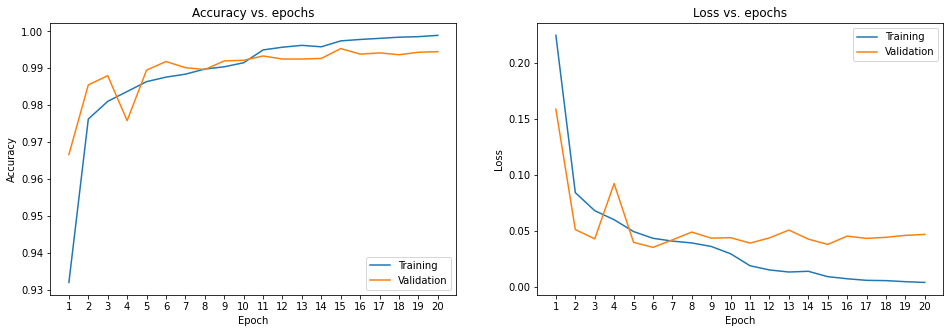

In [29]:
# 训练
history = train(vgg9_model, epochs=20)
plot_history(history)

,train_loss,train_accuracy,val_loss,val_accuracy,test_loss,test_accuracy,weight_number,train_time
custom2,0.001604,0.9995,0.031055,0.9952,0.016578,0.9958,435754,216.0
vgg9,0.001303,0.9995,0.037802,0.9953,0.021938,0.9955,1441482,370.0
custom1,0.004581,0.9984,0.028601,0.9935,0.020143,0.9947,73162,186.0
lenet,0.016427,0.9948,0.033910,0.9915,0.028727,0.9902,61750,157.0
mlp,0.006050,0.9987,0.088101,0.9803,0.072507,0.9813,101770,104.0


------------------------------------------------------------------------------------------------------------------------


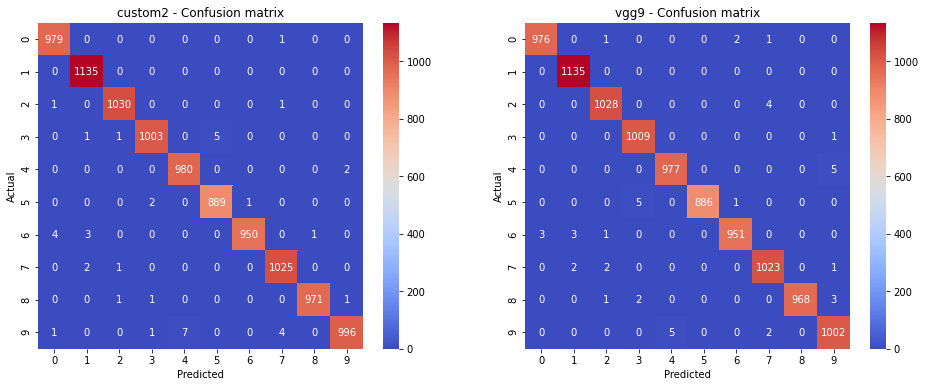

------------------------------------------------------------------------------------------------------------------------


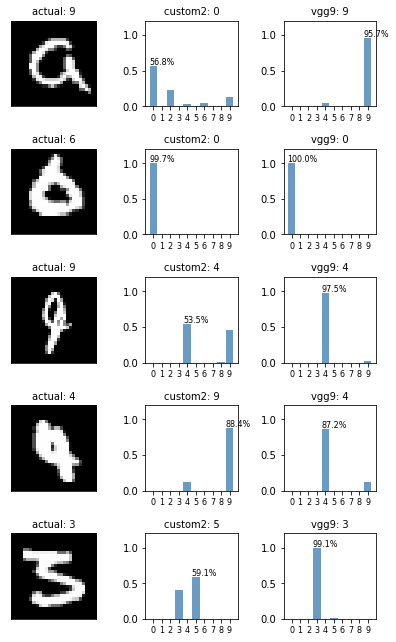

In [30]:
# 评估
vgg9_model = get_vgg9(input_shape, use_bn=use_bn, use_dropout=use_dropout, drop_out_rate=drop_out_rate)
vgg9_model = load_best_checkpoint(vgg9_model)
evaluate_show(vgg9_model, 
              train_time=history.train_time,
              train_dataset=train_dataset, 
              val_dataset=val_dataset, 
              test_dataset=test_dataset, 
              models=models
             )

# 混淆矩阵
print('-'*120)
plot_confusion_matrix(custom2_model, 
                      model2=vgg9_model, 
                      images=test_images, 
                      labels=test_labels)   

# 模型对比
print('-'*120)
plot_predicted_sample([custom2_model, vgg9_model], 
                      images=test_images, 
                      labels=test_labels,
                      sample_count=5)  

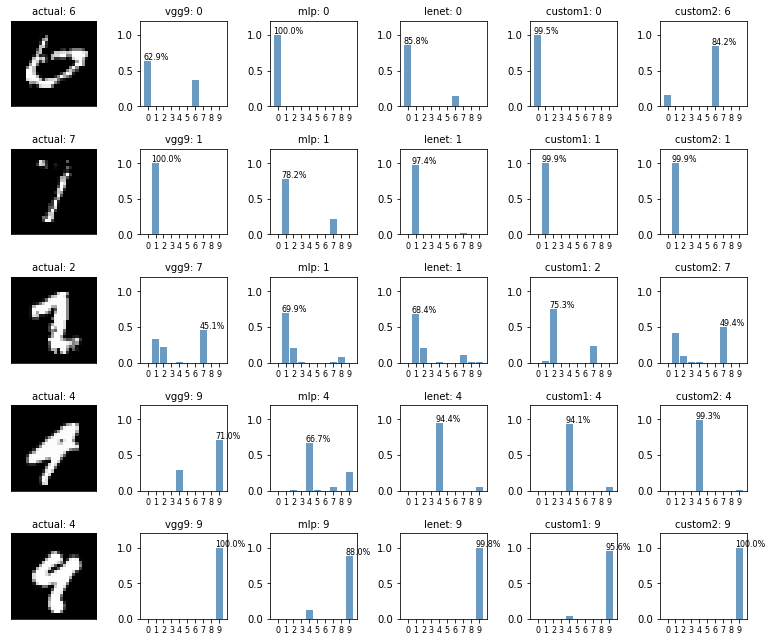

In [31]:
# 错误分析
plot_predicted_sample([vgg9_model, mlp_model, lenet_model, custom1_model, custom2_model], 
                      images=test_images, 
                      labels=test_labels,
                      sample_count=5)   

In [32]:
def get_block(x, filters, conv_count, kernel_size=(3, 3), padding='same', use_bn=True, 
              use_dropout=True, drop_out_rate=0.3):
    for i in range(conv_count):
        x = layers.Conv2D(filters, kernel_size, padding=padding, activation='relu')(x)
    if use_bn: x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    if use_dropout: x = layers.Dropout(drop_out_rate)(x)
    return x
    

def get_model(model_name,
              input_shape,
              dense_layer_count=1, 
              dense_layer_units=64,
              learning_rate=0.001,
              vgg_block_count=3,
              use_bn=True, 
              drop_out_rate=0):   
    input = layers.Input(shape=input_shape)
    use_dropout = drop_out_rate>0
    
    filter = 32
    x = get_block(input, filter, conv_count=2, use_bn=use_bn, use_dropout=use_dropout, drop_out_rate=drop_out_rate)
    for i in range(vgg_block_count-1):
        filter = filter*2
        x = get_block(x, filter, conv_count=2, use_bn=use_bn, use_dropout=use_dropout, drop_out_rate=drop_out_rate)
                    
    x = layers.Flatten()(x)
    for i in range(dense_layer_count):
        x = layers.Dense(128, activation='relu')(x)
        if use_dropout: x = layers.Dropout(drop_out_rate)(x)     
    x = layers.Dense(10)(x)
    
    model = Model(inputs=input, outputs=x, name=model_name) 
    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate),
                  loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])      
    model.checkpoint_path = './checkpoints/{}/checkpoint'.format(model.name)
    return model 

use_bn = True
use_dropout = True
drop_out_rate = 0.3
vgg_hpt_model = get_model('vgg_hpt',
                          input_shape,
                          dense_layer_count=1, 
                          dense_layer_units=128,
                          learning_rate=0.001,
                          vgg_block_count=4,
                          use_bn=True, 
                          drop_out_rate=0.3)
vgg_hpt_model.summary()

Model: "vgg_hpt"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_22 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 14, 14, 64)        1849

2020-12-22 01:48:04,063: INFO: start training


Epoch 1/20
1687/1687 [==============================] - 16s 9ms/step - loss: 0.2573 - accuracy: 0.9208 - val_loss: 0.0558 - val_accuracy: 0.9852
Epoch 2/20
1687/1687 [==============================] - 15s 9ms/step - loss: 0.0807 - accuracy: 0.9774 - val_loss: 0.0542 - val_accuracy: 0.9835
Epoch 3/20
1687/1687 [==============================] - 15s 9ms/step - loss: 0.0651 - accuracy: 0.9819 - val_loss: 0.0548 - val_accuracy: 0.9877
Epoch 4/20
1687/1687 [==============================] - 15s 9ms/step - loss: 0.0553 - accuracy: 0.9844 - val_loss: 0.0576 - val_accuracy: 0.9850
Epoch 5/20
1687/1687 [==============================] - 14s 8ms/step - loss: 0.0481 - accuracy: 0.9866 - val_loss: 0.0536 - val_accuracy: 0.9862
Epoch 6/20
1687/1687 [==============================] - 12s 7ms/step - loss: 0.0401 - accuracy: 0.9890 - val_loss: 0.0426 - val_accuracy: 0.9898
Epoch 7/20
1687/1687 [==============================] - 16s 9ms/step - loss: 0.0356 - accuracy: 0.9902 - val_loss: 0.0368 - val_ac

2020-12-22 01:54:24,890: INFO: finish training [elapsed time: 380.83 seconds]


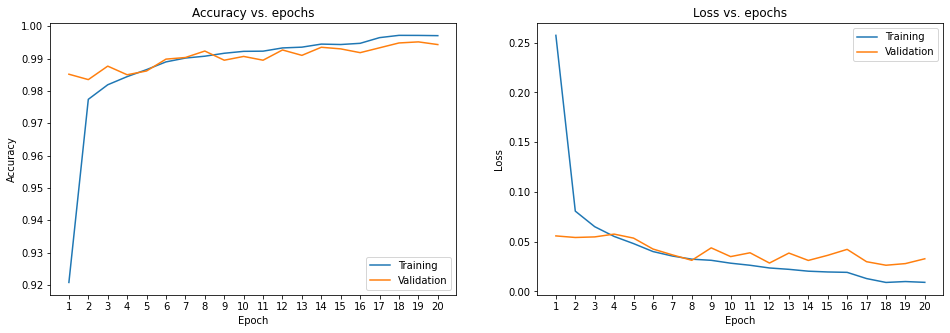

In [33]:
# 训练
history = train(vgg_hpt_model, epochs=20)
plot_history(history)

,train_loss,train_accuracy,val_loss,val_accuracy,test_loss,test_accuracy,weight_number,train_time
vgg_hpt,0.001876,0.9994,0.027987,0.9952,0.019130,0.9962,1206826,380.0
custom2,0.001604,0.9995,0.031055,0.9952,0.016578,0.9958,435754,216.0
vgg9,0.001303,0.9995,0.037802,0.9953,0.021938,0.9955,1441482,370.0
custom1,0.004581,0.9984,0.028601,0.9935,0.020143,0.9947,73162,186.0
lenet,0.016427,0.9948,0.033910,0.9915,0.028727,0.9902,61750,157.0
mlp,0.006050,0.9987,0.088101,0.9803,0.072507,0.9813,101770,104.0


------------------------------------------------------------------------------------------------------------------------


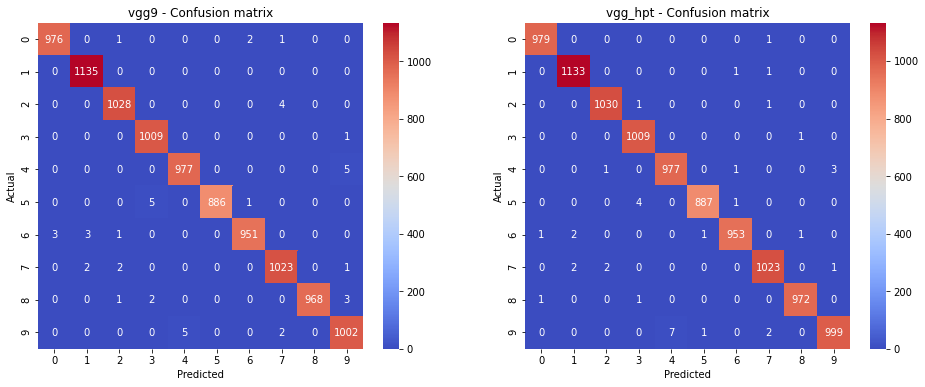

------------------------------------------------------------------------------------------------------------------------


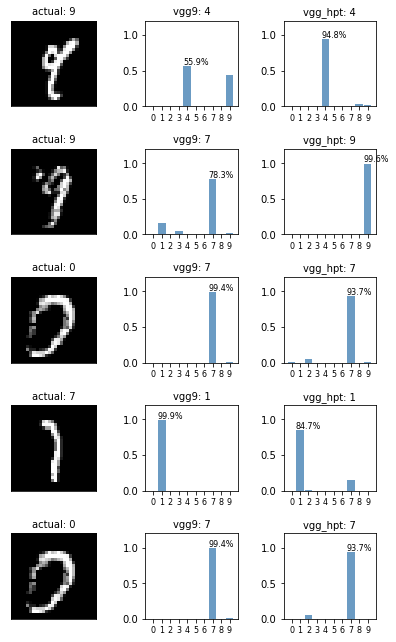

In [34]:
# 评估
vgg_hpt_model = get_model('vgg_hpt',
                          input_shape,
                          dense_layer_count=1, 
                          dense_layer_units=128,
                          learning_rate=0.001,
                          vgg_block_count=4,
                          use_bn=True, 
                          drop_out_rate=0.3)
vgg_hpt_model = load_best_checkpoint(vgg_hpt_model)
evaluate_show(vgg_hpt_model, 
              train_time=history.train_time,
              train_dataset=train_dataset, 
              val_dataset=val_dataset, 
              test_dataset=test_dataset, 
              models=models
             )

# 混淆矩阵
print('-'*120)
plot_confusion_matrix(vgg9_model, 
                      model2=vgg_hpt_model, 
                      images=test_images, 
                      labels=test_labels)   

# 模型对比
print('-'*120)
plot_predicted_sample([vgg9_model, vgg_hpt_model], 
                      images=test_images, 
                      labels=test_labels,
                      sample_count=5)  

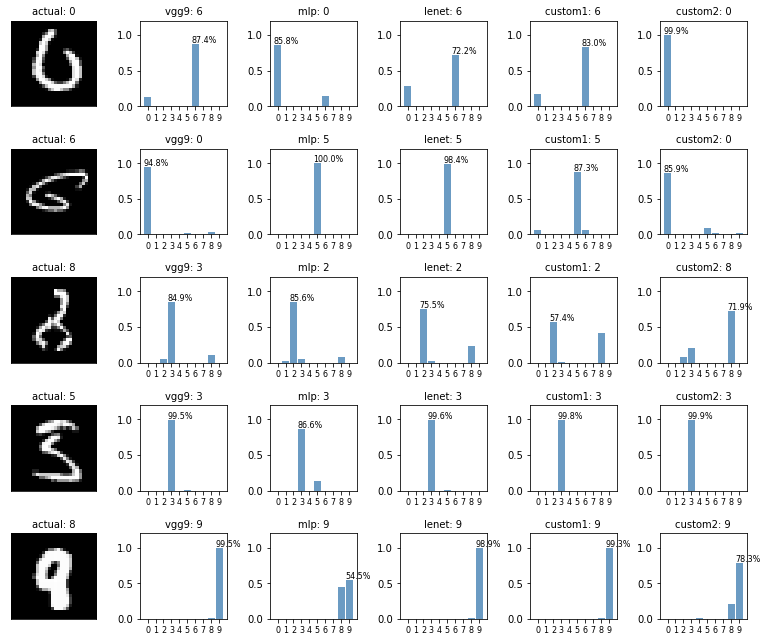

In [35]:
# 错误分析
plot_predicted_sample([vgg9_model, mlp_model, lenet_model, custom1_model, custom2_model], 
                      images=test_images, 
                      labels=test_labels,
                      sample_count=5) 

In [1]:
round(None, 6)

TypeError: type NoneType doesn't define __round__ method

In [2]:
45//11

4